# 0. Import Required Libraries 📚

In [ ]:
import os
import gc
import cv2
import time
import json
import torch
import shutil
import random
import numpy as np
from PIL import Image
from pathlib import Path
from random import sample
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import torchvision.transforms as T
import torchvision.models as models
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# 1. Dataset Loading 📂

## 1. Install and Configure the Kaggle API

Install the Kaggle Python package

In [ ]:
!pip install --quiet kaggle

On your local machine, go to your Kaggle account page (https://www.kaggle.com/), click on your profile icon → Account → Create New API Token. A file named kaggle.json will download.

select the file in below code

In [ ]:
files.upload()  # select your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirarefzadeh","key":"3179013a896cb7b2b543b35852dffdc2"}'}

Move kaggle.json to the proper location and set permission

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 2. Download the Football Player Segmentation Dataset

In [ ]:
!kaggle datasets download -d ihelon/football-player-segmentation
!unzip -q football-player-segmentation.zip -d ./football_data

Dataset URL: https://www.kaggle.com/datasets/ihelon/football-player-segmentation
License(s): CC0-1.0
 88% 280M/317M [00:00<00:00, 441MB/s]
100% 317M/317M [00:00<00:00, 482MB/s]


## 3. Sample 50 Images

Because we only need a subset of 50 images for the initial parts, we will randomly select 50 files from football_data/images/ and copy them into a new folder sample_images/.

In [ ]:
!mkdir -p sample_images

In [ ]:
all_images_dir = "football_data/images"
sample_dir = "sample_images"

all_filenames = sorted(os.listdir(all_images_dir))
sampled_filenames = random.sample(all_filenames, 50)

for fname in sampled_filenames:
    src_path = os.path.join(all_images_dir, fname)
    dst_path = os.path.join(sample_dir, fname)
    shutil.copyfile(src_path, dst_path)

## 4. Downscale Images to 1/8 or 1/16 of Original Size

The original images are 1920×1080 pixels. To avoid memory issues, we will resize each sampled image by a factor of 1/8 (i.e., new size: 240×135).we can Adjust the rescaling factor to 1/16 if needed (new size: 120×67), but 1/8 is usually a good trade-off between speed and retaining enough detail.

In [ ]:
!pip install --quiet opencv-python-headless

In [ ]:
downscaled_dir = Path("sample_images_downscaled")
downscaled_dir.mkdir(exist_ok=True)

scale_factor = 1 / 8

sample_dir_path = Path(sample_dir) # Convert the string to a Path object

for img_path in sample_dir_path.iterdir():

    img = cv2.imread(str(img_path))

    # Compute new dimensions
    height, width = img.shape[:2]
    new_w = int(width * scale_factor)
    new_h = int(height * scale_factor)

    # Resize with INTER_AREA
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Save
    save_path = downscaled_dir / img_path.name
    cv2.imwrite(str(save_path), resized)

## 5. Quick Visualization

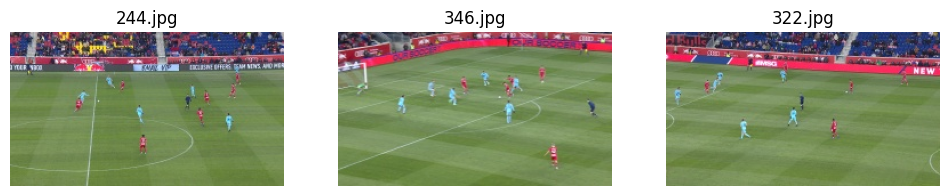

In [ ]:
# visualize 3 random downscaled images
downscaled_list = list(downscaled_dir.iterdir())
to_show = sample(downscaled_list, 3)

plt.figure(figsize=(12,4))
for i, img_path in enumerate(to_show, 1):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_path.name)
plt.show()


# 2. Creating Features ⚒️

## Imports and Global Paths

First, re‐run any imports and define the paths to your downscaled images folder.

In [ ]:
DOWNSCALED_DIR = Path("sample_images_downscaled")

image_filenames = sorted([p.name for p in DOWNSCALED_DIR.iterdir() if p.suffix.lower() in {".jpg", ".png"}])

## Helper: Generating (x, y) Coordinates

Most advanced feature sets will require normalized (x,y) pixel coordinates. we write a small utility that, given an image shape (H, W), returns two arrays of shape (H, W) containing the normalized x‐coordinate and y‐coordinate (in [0, 1]) for each pixel.

In [ ]:
def get_normalized_xy(h, w):
    # Create a row vector for x: 0,1,2,...,w-1, then divide by (w-1)
    x_coords = np.linspace(0, 1, w, dtype=np.float32)
    # Create a column vector for y: 0,1,2,...,h-1, then divide by (h-1)
    y_coords = np.linspace(0, 1, h, dtype=np.float32)
    X_norm = np.tile(x_coords[np.newaxis, :], (h, 1))   # shape: (h, w)
    Y_norm = np.tile(y_coords[:, np.newaxis], (1, w))   # shape: (h, w)
    return X_norm, Y_norm

 test this on one downscaled image to confirm:

In [ ]:
img0 = cv2.imread(str(DOWNSCALED_DIR / image_filenames[0]))
h0, w0 = img0.shape[:2]
X0, Y0 = get_normalized_xy(h0, w0)

print("X0 min/max:", X0.min(), X0.max())
print("Y0 min/max:", Y0.min(), Y0.max())
print("Shapes X0, Y0:", X0.shape, Y0.shape)

X0 min/max: 0.0 1.0
Y0 min/max: 0.0 1.0
Shapes X0, Y0: (135, 240) (135, 240)


## Feature Set 1: Color Only (RGB)

The simplest feature vector for each pixel is its raw color (R, G, B).

*   Read a downscaled image as a NumPy array in BGR order (because OpenCV reads in BGR).

*   Convert to RGB (optional, but more intuitive).

*   Reshape from (H, W, 3) → (H*W, 3).






In [ ]:
def extract_features_rgb(image_bgr):
    # Convert BGR→RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    # Reshape to (H*W, 3)
    features = image_rgb.reshape(-1, 3).astype(np.float32)
    return features

# test on one image
img0 = cv2.imread(str(DOWNSCALED_DIR / image_filenames[0]))
feat1 = extract_features_rgb(img0)
print("Feature Set 1 shape (RGB only) for one image:", feat1.shape)
# Should be (H*W, 3) -> (240*135=32400, 3)


Feature Set 1 shape (RGB only) for one image: (32400, 3)


## Feature Set 2: RGB + Normalized (x, y)

Combining raw color with pixel coordinates often helps clustering to respect spatial contiguity. We’ll:

*   Compute features_rgb as above.

*   Compute (X_norm, Y_norm) for that image.

*   Reshape X_norm and Y_norm into column vectors of length H·W.

*   Concatenate horizontally: [R, G, B, x_norm, y_norm] → shape (H·W, 5).


In [ ]:
def extract_features_rgb_xy(image_bgr):
    """
    Input:
      - image_bgr: array (H, W, 3)
    Output:
      - features_rgb_xy: array (H*W, 5) ≔ [R, G, B, x_norm, y_norm].
    """
    # color
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    flat_rgb = image_rgb.reshape(-1, 3).astype(np.float32)

    # normalized x,y
    X_norm, Y_norm = get_normalized_xy(h, w)               # both shape (h, w)
    flat_x = X_norm.reshape(-1, 1)                         # shape (h*w, 1)
    flat_y = Y_norm.reshape(-1, 1)                         # shape (h*w, 1)

    # concatenate → shape (h*w, 5)
    features = np.concatenate([flat_rgb, flat_x, flat_y], axis=1)
    return features

# Test on one image
feat2 = extract_features_rgb_xy(img0)
print("Feature Set 2 shape (RGB + XY) for one image:", feat2.shape)

Feature Set 2 shape (RGB + XY) for one image: (32400, 5)


## Feature Set 3: CIELab Color + Normalized (x, y)

RGB is not perceptually uniform. Converting to CIELab often yields better clustering of colors. We’ll:

*   Convert BGR→Lab (using OpenCV’s COLOR_BGR2Lab).

*   Reshape (H, W, 3) → (H·W, 3).

*   Compute (X_norm, Y_norm) as before.

*   Concatenate → shape (H·W, 5) = [L, a, b, x_norm, y_norm].

In [ ]:
def extract_features_lab_xy(image_bgr):
    """
    Input:
      - image_bgr: array (H, W, 3)
    Output:
      - features_lab_xy: array (H*W, 5) ≔ [L, a, b, x_norm, y_norm].
    """
    # Convert BGR→Lab
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab).astype(np.float32)
    h, w = image_lab.shape[:2]
    flat_lab = image_lab.reshape(-1, 3)

    # Normalized x,y
    X_norm, Y_norm = get_normalized_xy(h, w)
    flat_x = X_norm.reshape(-1, 1)
    flat_y = Y_norm.reshape(-1, 1)

    # Concatenate: (h*w, 3) with (h*w, 2) → (h*w, 5)
    features = np.concatenate([flat_lab, flat_x, flat_y], axis=1)
    return features

# Test on one image
feat3 = extract_features_lab_xy(img0)
print("Feature Set 3 shape (Lab + XY) for one image:", feat3.shape)

Feature Set 3 shape (Lab + XY) for one image: (32400, 5)


## Feature Set 4: Texture (Gradient Magnitude) + Color + Position

Optionally, we can compute a per‐pixel “texture” feature. A common choice is the gradient magnitude (e.g. Sobel) as a proxy for edges. That way, pixels on edges (junctures between player and background) carry a distinct feature value.

*   Convert the image to grayscale.

*   Compute the Sobel gradient in x (Gx) and in y (Gy).

*   Compute gradient magnitude: sqrt(Gx² + Gy²).

*   Normalize or scale as needed.

*   Stack it with RGB (or Lab) and (x_norm, y_norm).

Below we show RGB + gradient + XY. You can analogously replace “RGB” with “Lab” if you prefer.

In [ ]:
def extract_features_rgb_grad_xy(image_bgr):
    """
    Input:
      - image_bgr: array (H, W, 3)
    Output:
      - features_rgb_grad_xy: array (H*W, 6) ≔ [R, G, B, grad_mag, x_norm, y_norm].
    """
    # Convert to RGB for consistency
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    h, w = image_rgb.shape[:2]
    flat_rgb = image_rgb.reshape(-1, 3)

    # compute grayscale
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Sobel gradients
    Gx = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    Gy = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    grad_mag = np.sqrt(Gx**2 + Gy**2)  # shape (h, w)

    # normalize gradient magnitude to [0, 1]
    grad_norm = cv2.normalize(grad_mag, None, alpha=0, beta=1,
                              norm_type=cv2.NORM_MINMAX).astype(np.float32)

    flat_grad = grad_norm.reshape(-1, 1)  # shape (h*w, 1)

    # normalized x,y
    X_norm, Y_norm = get_normalized_xy(h, w)
    flat_x = X_norm.reshape(-1, 1)
    flat_y = Y_norm.reshape(-1, 1)

    # concatenate → shape (h*w, 3 + 1 + 1 + 1) = (h*w, 6)
    features = np.concatenate([flat_rgb, flat_grad, flat_x, flat_y], axis=1)
    return features

# Test on one image
feat4 = extract_features_rgb_grad_xy(img0)
print("Feature Set 4 shape (RGB + grad + XY) for one image:", feat4.shape)

Feature Set 4 shape (RGB + grad + XY) for one image: (32400, 6)


## Build Feature Dictionaries for All 50 Images

Now that you have four extraction functions, let’s loop over all 50 images and build separate dictionaries mapping filename → feature_matrix. We’ll store them in memory for now (but you could also save each array to disk if you run out of RAM).

In [ ]:
# Prepare empty dictionaries
features_rgb_dict      = {}
features_rgb_xy_dict   = {}
features_lab_xy_dict   = {}
features_rgb_grad_xy_dict = {}

for fname in image_filenames:
    img_path = DOWNSCALED_DIR / fname
    img_bgr = cv2.imread(str(img_path))

    if img_bgr is None:
        print(f"Warning: Could not read {fname}. Skipping.")
        continue

    # Extract each feature set
    feat1 = extract_features_rgb(img_bgr)             # (H*W, 3)
    feat2 = extract_features_rgb_xy(img_bgr)          # (H*W, 5)
    feat3 = extract_features_lab_xy(img_bgr)          # (H*W, 5)
    feat4 = extract_features_rgb_grad_xy(img_bgr)     # (H*W, 6)

    # Store in dict
    features_rgb_dict[fname] = feat1
    features_rgb_xy_dict[fname] = feat2
    features_lab_xy_dict[fname] = feat3
    features_rgb_grad_xy_dict[fname] = feat4

print("Built feature dictionaries for all 50 images.")

Built feature dictionaries for all 50 images.


## Visualizing Feature Distributions

To “report and evaluate” these feature sets qualitatively, it can help to look at, for example:

*   Scatter in Color Space: randomly sample 500 pixels, plot R vs. G vs. B or Lab channels.

*   x–y vs. color: see if the addition of x_norm,y_norm helps cluster players spatially.

*   Histogram of gradient magnitudes: see how strong edges are distributed.

Below is a quick example of visualizing a 2D scatter of (R, G) for a single image (we down‐sample the pixels for plotting).

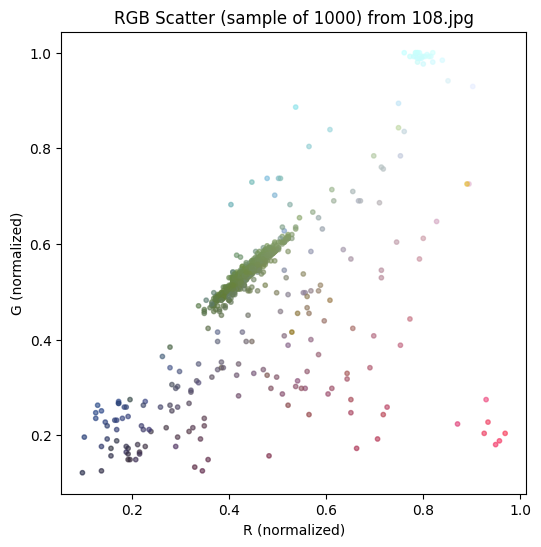

In [ ]:
import matplotlib.pyplot as plt

# Take one example image’s RGB features
ex_fname = image_filenames[0]
feat_rgb = features_rgb_dict[ex_fname]
num_pixels = feat_rgb.shape[0]

# Randomly pick 1000 indices
rand_idx = np.random.choice(num_pixels, size=1000, replace=False)
sampled = feat_rgb[rand_idx, :] / 255.0  # scale to [0, 1] for plotting

# Plot R vs G, coloring each point by its own (R,G,B)
plt.figure(figsize=(6, 6))
plt.scatter(sampled[:, 0], sampled[:, 1],
            c=sampled, s=10, alpha=0.6)
plt.xlabel("R (normalized)")
plt.ylabel("G (normalized)")
plt.title(f"RGB Scatter (sample of 1000) from {ex_fname}")
plt.show()

# 3. Cluster pixels 🚀

## Helper Functions for Scaling and Visualization

In [ ]:
def scale_features(features):
    """
    Scales features using StandardScaler. This is essential for distance-based clustering.
    Returns the scaled features and the fitted scaler object.
    """
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, scaler

def perform_clustering(features, algorithm, params):
    algorithm = algorithm.lower()
    print(f"--- Running {algorithm.upper()} ---")
    start_time = time.time()

    if algorithm == 'kmeans':
        model = KMeans(**params)
        labels = model.fit_predict(features)

    elif algorithm == 'dbscan':
        model = DBSCAN(**params)
        labels = model.fit_predict(features)

    elif algorithm == 'agglomerative':
        if 'n_clusters' not in params:
            raise ValueError("AgglomerativeClustering requires 'n_clusters' in params.")
        model = AgglomerativeClustering(**params)
        labels = model.fit_predict(features)

    else:
        raise ValueError("Unsupported algorithm. Use 'kmeans', 'dbscan', or 'agglomerative'.")

    end_time = time.time()
    print(f"Clustering completed in {end_time - start_time:.2f} seconds.")

    return labels


def visualize_segmentation(image_bgr, labels, title="Clustering Results"):
    """
    Displays the original image alongside its clustered segmentation mask.
    """
    h, w = image_bgr.shape[:2]

    # Ensure the labels can be reshaped to the image dimensions
    if labels.size != h * w:
        print(f"Error: Label size {labels.size} doesn't match image dimensions {h*w}.")
        return

    segmented_image = labels.reshape(h, w)

    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Segmented Image
    plt.subplot(1, 2, 2)
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('viridis', len(unique_labels))
    plt.imshow(segmented_image, cmap=cmap)
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Parameter Tuning Functions

In [ ]:
def tune_kmeans_k(scaled_features, max_k=15, sample_frac=0.2):
    """
    Calculates and plots inertia and silhouette scores for a range of K values
    to help determine the optimal number of clusters for K-Means.
    """
    k_values = range(2, max_k + 1)
    inertias = []
    silhouette_scores = []

    print(f"Tuning K-Means: Testing K from 2 to {max_k}...")

    # Subsample for faster tuning
    n_pixels = scaled_features.shape[0]
    sample_size = int(n_pixels * sample_frac)
    sample_indices = np.random.choice(n_pixels, sample_size, replace=False)
    features_sample = scaled_features[sample_indices, :]

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(features_sample)
        inertias.append(kmeans.inertia_)

        # Silhouette score is computationally expensive, but very useful
        score = silhouette_score(features_sample, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"  K={k:<2} | Inertia: {kmeans.inertia_:>10.2f} | Silhouette Score: {score:.4f}")

    # Plotting the results
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Optimal K')
    plt.grid(True)

    plt.show()


def tune_dbscan_eps(scaled_features, min_samples=15):
    """
    Calculates and plots the k-distance graph to help determine the
    optimal `eps` value for DBSCAN.
    """
    print(f"Tuning DBSCAN 'eps' using a k-distance plot (min_samples = {min_samples})...")
    # n_neighbors is min_samples because that's the definition of a core point
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(scaled_features)
    distances, _ = nn.kneighbors(scaled_features)

    # Distances are sorted for each point, we want the k-th distance (last column)
    k_distances = np.sort(distances[:, -1])

    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.xlabel("Points (sorted by distance)")
    plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance (eps)")
    plt.title("k-Distance Graph for DBSCAN `eps` Tuning")
    plt.grid(True)
    plt.show()
    print("Find the 'elbow' of this curve to choose your 'eps' value.")

## Tune parameters

In [ ]:
image_name = image_filenames[0]
img_bgr = cv2.imread(str(DOWNSCALED_DIR / image_name))

features = features_lab_xy_dict[image_name]
features_scaled, scaler = scale_features(features)

### Tune K for K-Means using the scaled features

Tuning K-Means: Testing K from 2 to 10...
  K=2  | Inertia: 4379787.50 | Silhouette Score: 0.7170
  K=3  | Inertia: 2284807.25 | Silhouette Score: 0.7528
  K=4  | Inertia: 1547526.25 | Silhouette Score: 0.7365
  K=5  | Inertia: 1280301.38 | Silhouette Score: 0.4029
  K=6  | Inertia:  994856.62 | Silhouette Score: 0.4161
  K=7  | Inertia:  928065.00 | Silhouette Score: 0.3569
  K=8  | Inertia:  809584.81 | Silhouette Score: 0.3458
  K=9  | Inertia:  723931.38 | Silhouette Score: 0.3428
  K=10 | Inertia:  654431.88 | Silhouette Score: 0.3764


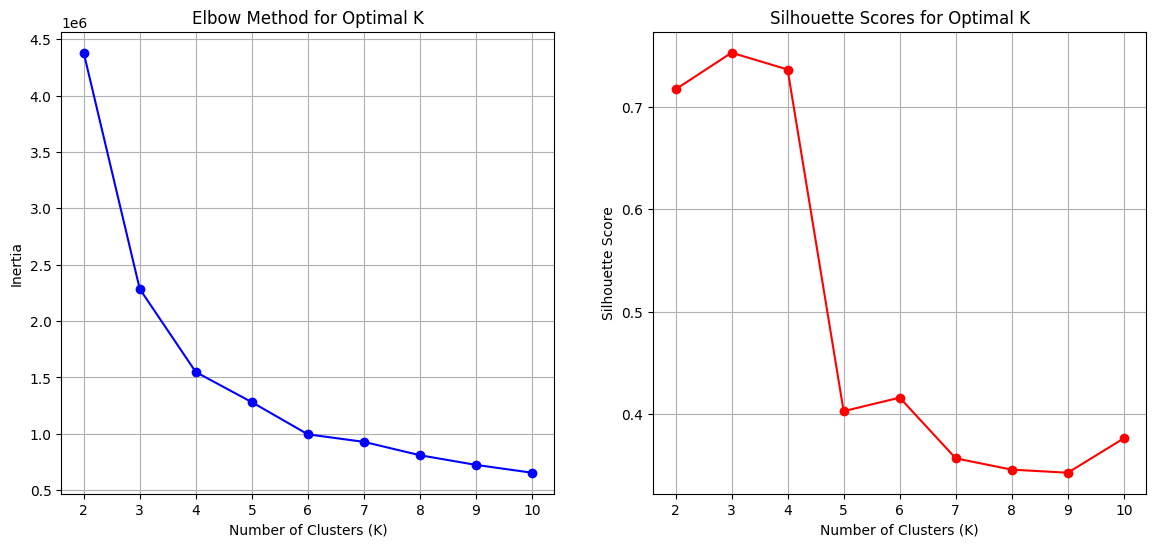

In [ ]:
tune_kmeans_k(features, max_k=10)

### Tune eps for DBSCAN

Tuning DBSCAN 'eps' using a k-distance plot (min_samples = 15)...


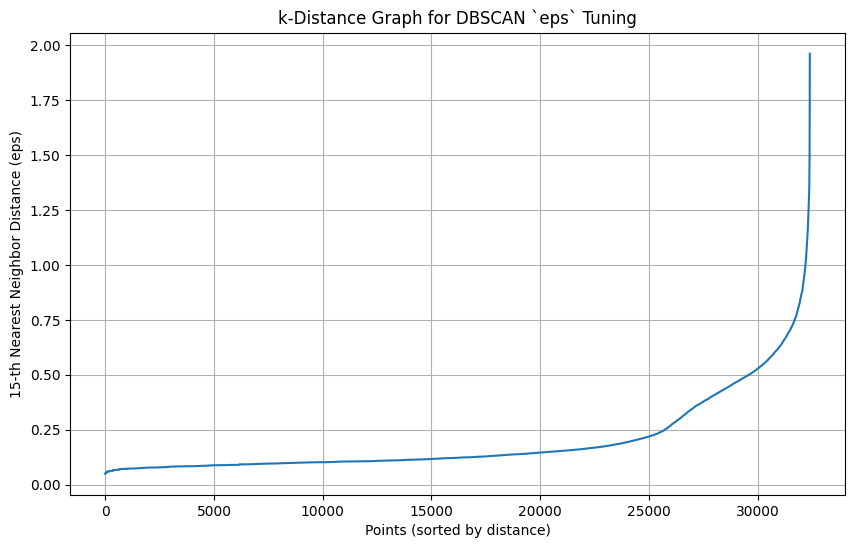

Find the 'elbow' of this curve to choose your 'eps' value.


In [ ]:
tune_dbscan_eps(features_scaled, min_samples=15)

## Main Clustering and Comparison

Working with image '108.jpg' and features 'Lab + XY'.
Feature matrix shape: (32400, 5)
--- Running KMEANS ---
Clustering completed in 0.03 seconds.


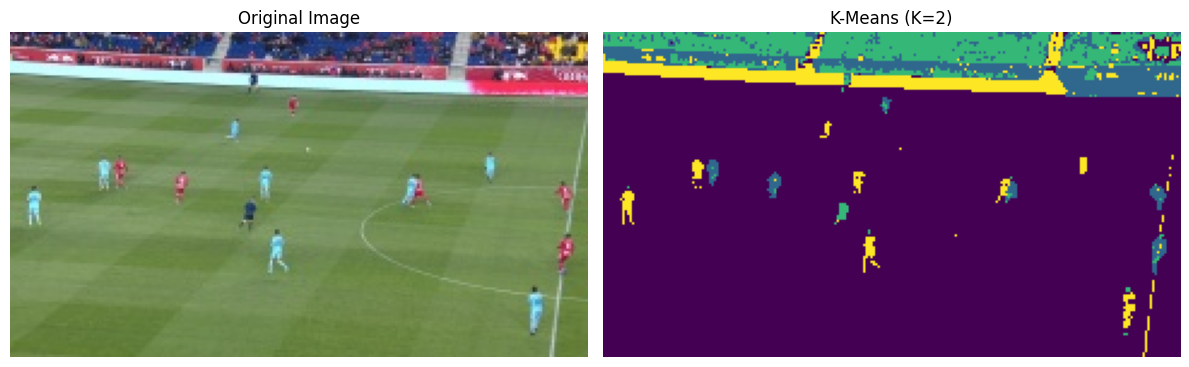

--- Running DBSCAN ---
Clustering completed in 1.79 seconds.


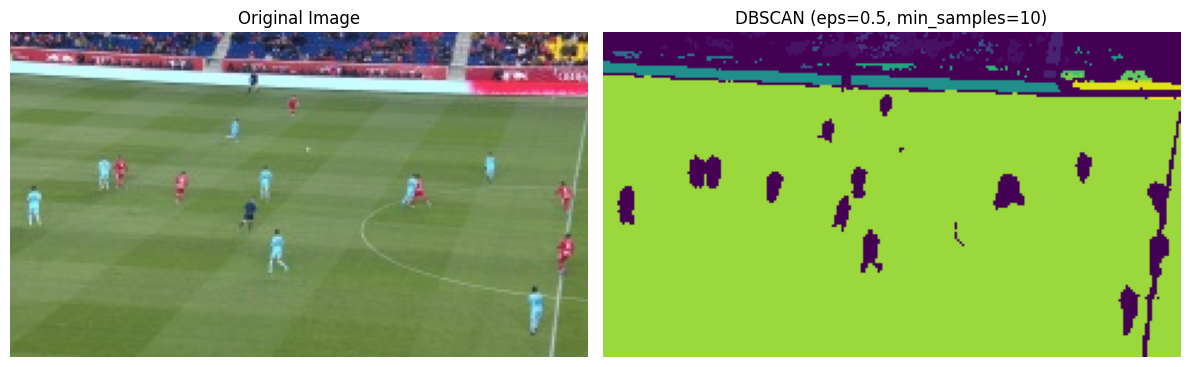

--- Running AGGLOMERATIVE ---
Clustering completed in 52.26 seconds.


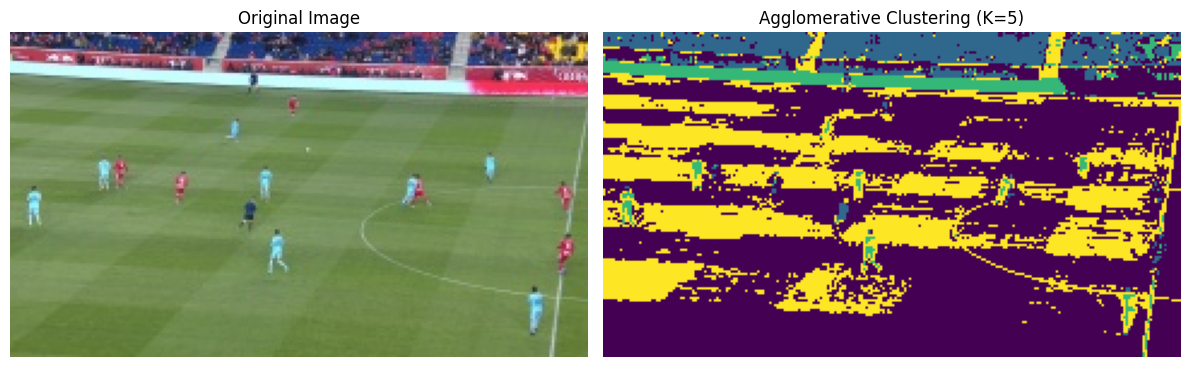

In [ ]:
print(f"Working with image '{image_name}' and features 'Lab + XY'.")
print(f"Feature matrix shape: {features.shape}")

# K-Means
params_kmeans = {'n_clusters':4, 'n_init': 'auto', 'random_state': 42}
kmeans_labels = perform_clustering(features, 'kmeans', params_kmeans)
visualize_segmentation(img_bgr, kmeans_labels, title="K-Means (K=2)")

# DBSCAN
params_dbscan = {'eps': 0.3, 'min_samples': 15}
dbscan_labels = perform_clustering(features_scaled, 'dbscan', params_dbscan)
visualize_segmentation(img_bgr, dbscan_labels, title=f"DBSCAN (eps=0.5, min_samples=10)")

# Agglomerative Clustering
params_agg = {'n_clusters': 4, 'linkage': 'complete'}
agg_labels = perform_clustering(features_scaled, 'agglomerative', params_agg)
visualize_segmentation(img_bgr, agg_labels, title="Agglomerative Clustering (K=5)")

## clustring with difrence feature


Clustering with RGB Only features...
--- Running KMEANS ---
Clustering completed in 0.06 seconds.


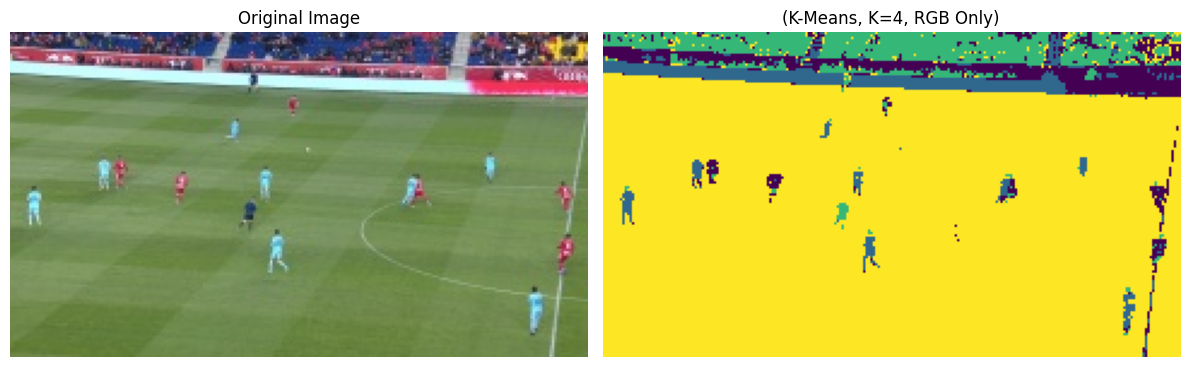


Clustering with RGB + XY features...
--- Running KMEANS ---
Clustering completed in 0.06 seconds.


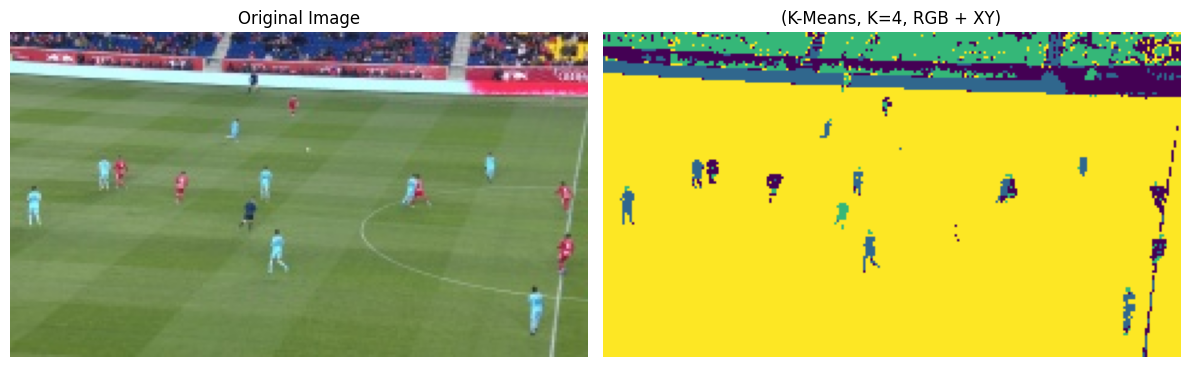


Clustering with Lab + XY features...
--- Running KMEANS ---
Clustering completed in 0.04 seconds.


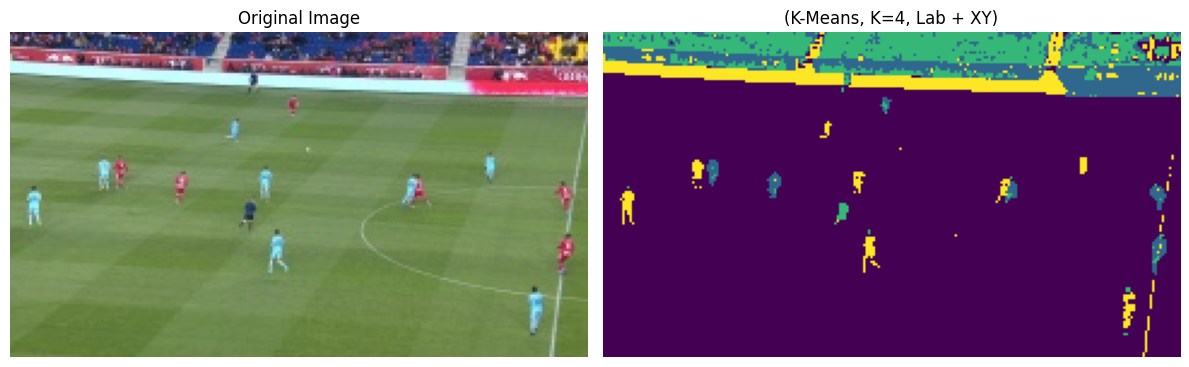


Clustering with RGB + Grad + XY features...
--- Running KMEANS ---
Clustering completed in 0.06 seconds.


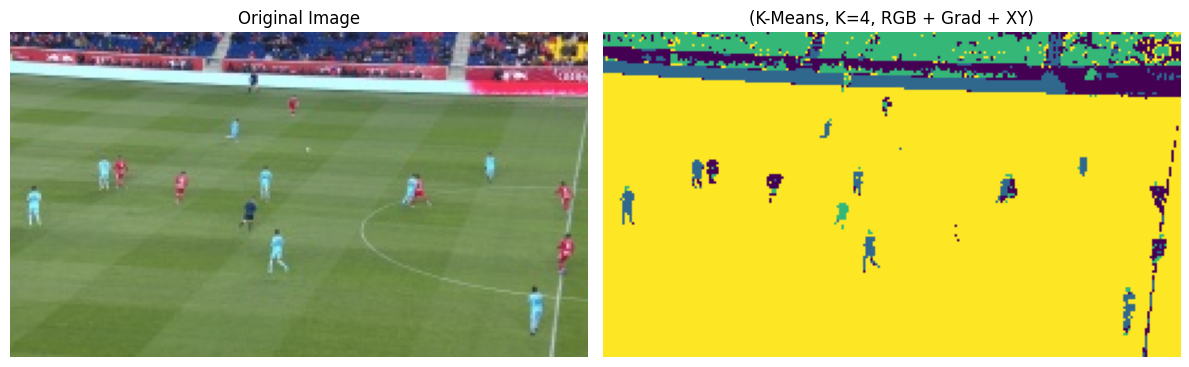

In [ ]:
image_name = image_filenames[0]
img_bgr = cv2.imread(str(DOWNSCALED_DIR / image_name))

all_feature_sets = [
    (features_rgb_dict, "RGB Only"),
    (features_rgb_xy_dict, "RGB + XY"),
    (features_lab_xy_dict, "Lab + XY"),
    (features_rgb_grad_xy_dict, "RGB + Grad + XY")
]

for feature_dict, feature_name in all_feature_sets:
  features = feature_dict[image_name]

  params_kmeans = {
      'n_clusters': 4,
      'n_init': 'auto',
      'random_state': 42
  }
  print(f"\nClustering with {feature_name} features...")
  kmeans_labels = perform_clustering(features, 'kmeans', params_kmeans)
  visualize_segmentation(img_bgr, kmeans_labels, title=f"(K-Means, K=4, {feature_name})")


Clustering with RGB Only features...
--- Running KMEANS ---
Clustering completed in 0.04 seconds.


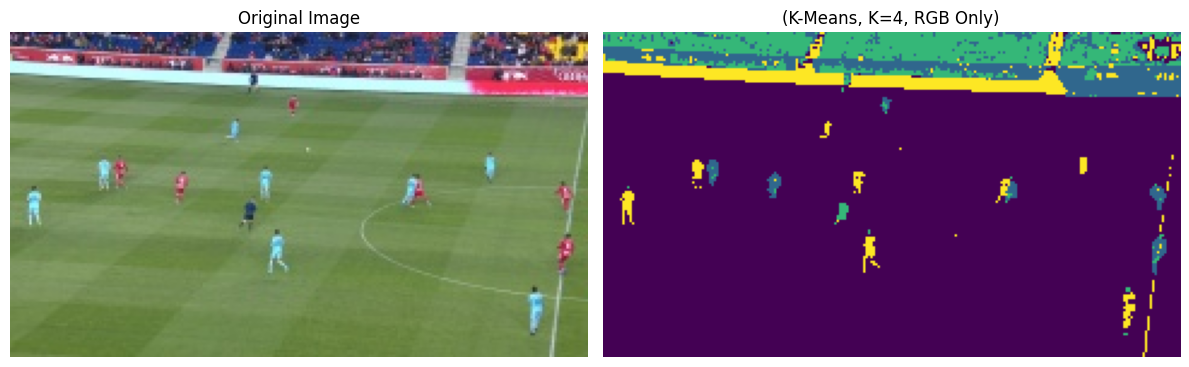


Clustering with RGB + XY features...
--- Running KMEANS ---
Clustering completed in 0.04 seconds.


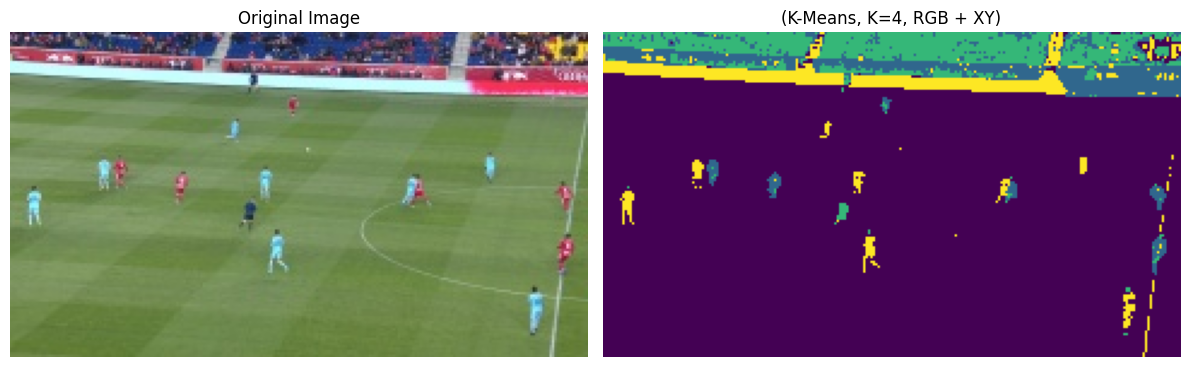


Clustering with Lab + XY features...
--- Running KMEANS ---
Clustering completed in 0.04 seconds.


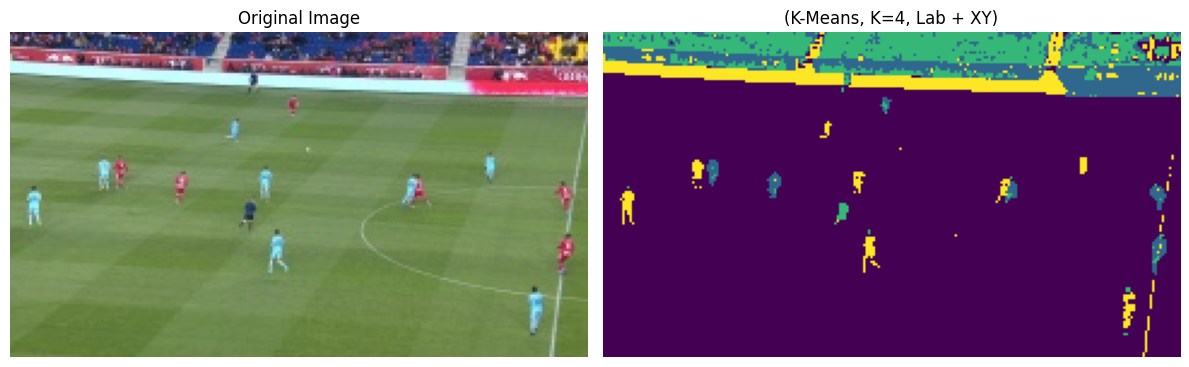


Clustering with RGB + Grad + XY features...
--- Running KMEANS ---
Clustering completed in 0.03 seconds.


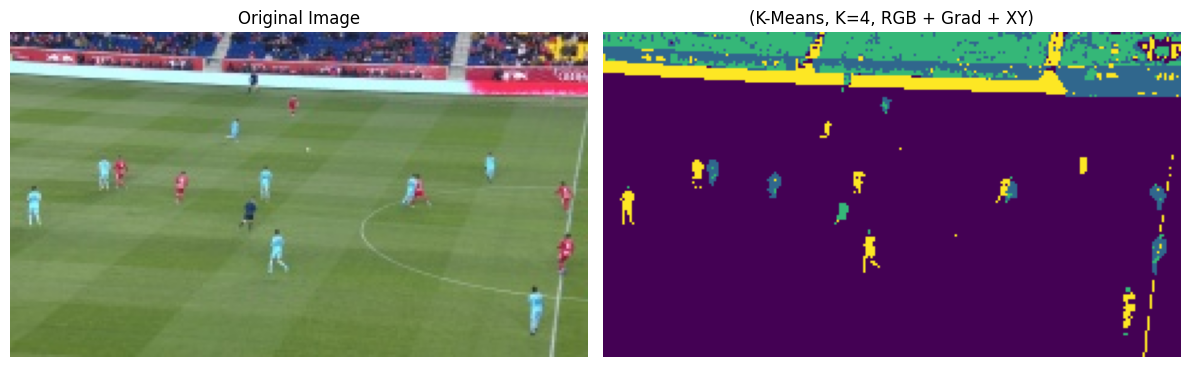

In [ ]:
image_name = image_filenames[0]
img_bgr = cv2.imread(str(DOWNSCALED_DIR / image_name))

all_feature_sets = [
    (features_rgb_dict, "RGB Only"),
    (features_rgb_xy_dict, "RGB + XY"),
    (features_lab_xy_dict, "Lab + XY"),
    (features_rgb_grad_xy_dict, "RGB + Grad + XY")
]

for feature_dict, feature_name in all_feature_sets:
  features = features_lab_xy_dict[image_name]

  params_kmeans = {
      'n_clusters': 4,
      'n_init': 'auto',
      'random_state': 42
  }
  print(f"\nClustering with {feature_name} features...")
  kmeans_labels = perform_clustering(features, 'kmeans', params_kmeans)
  visualize_segmentation(img_bgr, kmeans_labels, title=f"(K-Means, K=4, {feature_name})")

# 4. Filtering and Merging 🩻

filter_and_merge_clusters function:


*   It first calculates the size of each cluster from the input labels.

*   It identifies the largest cluster and assumes it's the background (the field).

*   It creates a filtered_mask by keeping only the clusters that are not the background and are larger than a min_size_threshold (to remove noise).

*   It then performs a morphological closing operation on this mask. We use cv2.morphologyEx with cv2.MORPH_CLOSE. This operation is great for closing small gaps and connecting nearby components, which is exactly what we need to merge fragmented parts of players.

*   The function returns both the intermediate filtered mask and the final merged mask so you can see the effect of each step.












In [ ]:
def filter_and_merge_clusters(labels, min_size_threshold=100):
    """
    Filters out the largest cluster (assumed to be background) and small noise clusters,
    then merges remaining player segments using morphological closing.
    """

    # Step 1: Filter clusters by size

    # Find the unique cluster IDs and their sizes
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))

    # find largest cluster
    if len(counts) > 0:
        largest_cluster_id = unique_labels[np.argmax(counts)]
    else:
        h, w = int(np.sqrt(labels.size)), int(np.sqrt(labels.size))
        return np.zeros((h,w), dtype=np.uint8)

    print(f"Largest cluster (background) is ID {largest_cluster_id} with {cluster_sizes[largest_cluster_id]} pixels.")

    # Create a binary mask
    # Let's get the correct shape from an image
    temp_img = cv2.imread(str(DOWNSCALED_DIR / image_filenames[0]))
    h, w = temp_img.shape[:2]

    labels_2d = labels.reshape(h, w)

    filtered_mask = np.zeros_like(labels_2d, dtype=np.uint8)

    for label_id, size in cluster_sizes.items():
        # Not the largest cluster AND bigger than the noise threshold
        if label_id != largest_cluster_id and size > min_size_threshold:
            filtered_mask[labels_2d == label_id] = 255 # Mark this cluster's pixels as white

    # Step 2: Merge adjacent clusters using morphological closing

    # A kernel determines the shape and size of the neighborhood to consider.
    # An elliptical kernel is often good for natural shapes like players.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # It closes small holes and gaps between nearby objects.
    merged_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return filtered_mask, merged_mask

--- K-MEANS EXAMPLE ---
--- Running KMEANS ---
Clustering completed in 0.04 seconds.


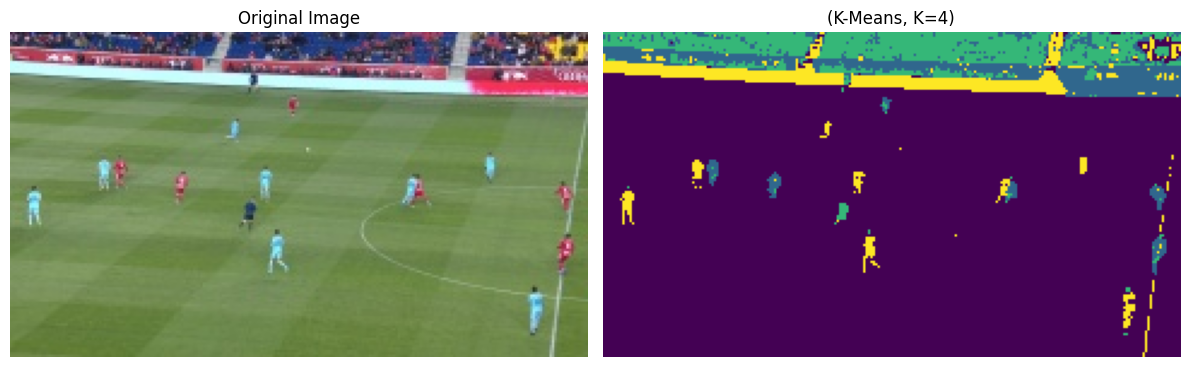

--- Filtering and Merging for 108.jpg ---
Largest cluster (background) is ID 0 with 26444 pixels.


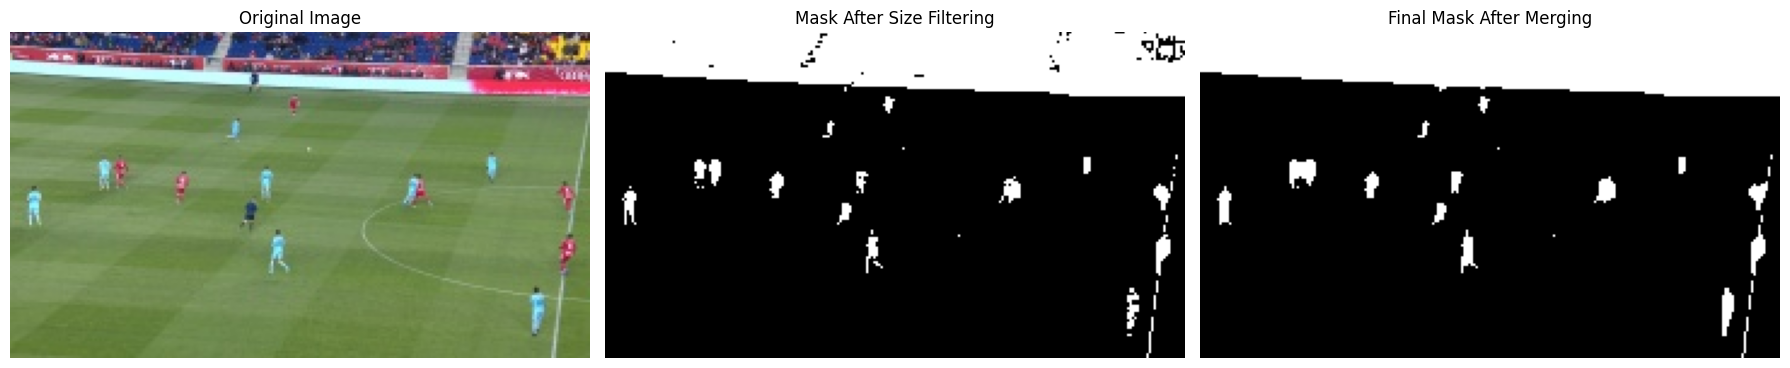

In [ ]:
image_name = image_filenames[0]
img_bgr = cv2.imread(str(DOWNSCALED_DIR / image_name))
features = features_lab_xy_dict[image_name]

features_scaled, scaler = scale_features(features)

# Example with K-Means
print("--- K-MEANS EXAMPLE ---")
params_kmeans = {
    'n_clusters': 4,
    'n_init': 'auto',
    'random_state': 42
}
kmeans_labels = perform_clustering(features, 'kmeans', params_kmeans)
visualize_segmentation(img_bgr, kmeans_labels, title="(K-Means, K=4)")


print(f"--- Filtering and Merging for {image_name} ---")
filtered_mask, final_mask = filter_and_merge_clusters(kmeans_labels, min_size_threshold=100)

plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Mask after Filtering
plt.subplot(1, 3, 2)
plt.imshow(filtered_mask, cmap='gray')
plt.title('Mask After Size Filtering')
plt.axis('off')

# Mask after Merging
plt.subplot(1, 3, 3)
plt.imshow(final_mask, cmap='gray')
plt.title('Final Mask After Merging')
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Even More Clustering! 💣

The goal of this section is to take our final binary mask from the previous step and treat each separate white region (which should be a player) as an individual object. We'll use a specific computer vision technique to assign a unique ID to each of these regions and find their centers.

This process is formally known as finding connected components. OpenCV has a perfect tool for this: cv2.connectedComponentsWithStats. It analyzes a binary image and gives us everything we need: the number of separate objects, a new image where each object is labeled with a different integer, and useful statistics like the centroid (center point) of each object.

In [ ]:
def find_player_centroids(binary_mask, min_area_threshold=20):
    """
    Finds and labels each separate player segment (connected component) in a binary mask,
    filtering out components that are too small.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    # Filter out small components
    filtered_labels = np.zeros_like(labels)
    filtered_centroids = []

    # Start from 1 to ignore the background (label 0)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]

        # If the area is large enough, keep it
        if area >= min_area_threshold:
            # Add the component to our new filtered mask
            filtered_labels[labels == i] = i
            # Add the centroid to our list
            filtered_centroids.append(centroids[i])

    return filtered_labels, np.array(filtered_centroids)

--- Finding Centroids for 108.jpg ---


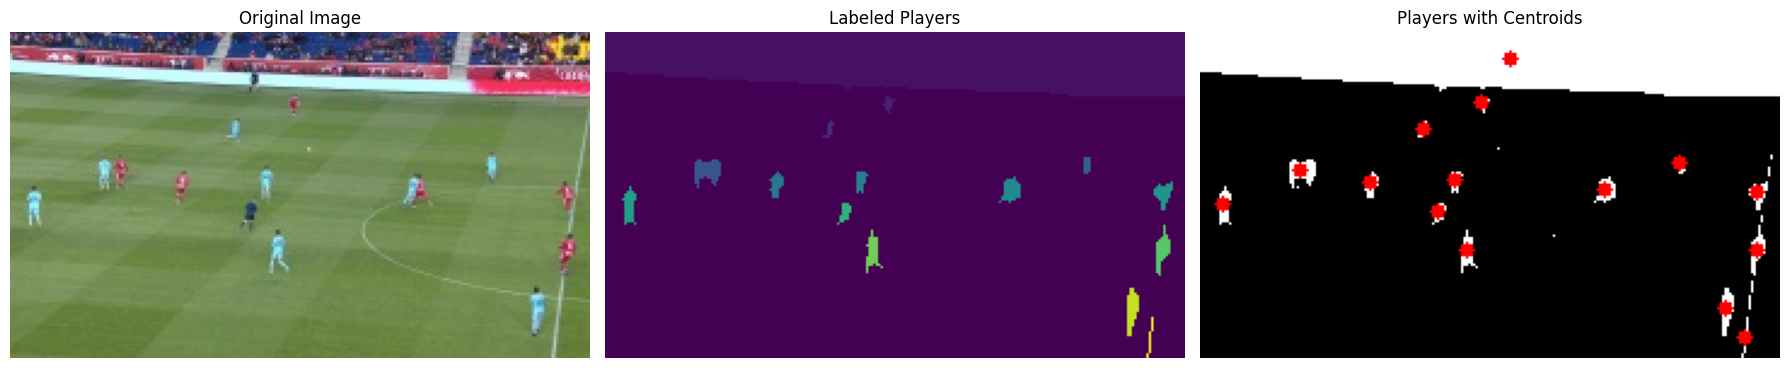

Detected 15 players.


In [ ]:
image_name = image_filenames[0]

print(f"--- Finding Centroids for {image_name} ---")
labeled_players, player_centers = find_player_centroids(final_mask, 10)

# Visualize the final results

# Create a color image from the final mask to draw on
final_mask_color = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

# Draw a red circle at the center of each detected player
for center in player_centers:
    center_x, center_y = int(center[0]), int(center[1])
    cv2.circle(final_mask_color, (center_x, center_y), radius=3, color=(255, 0, 0), thickness=-1 )

plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
img_bgr = cv2.imread(str(DOWNSCALED_DIR / image_name))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Labeled Players (each player has a different color)
plt.subplot(1, 3, 2)
plt.imshow(labeled_players, cmap='viridis')
plt.title('Labeled Players')
plt.axis('off')

# Final Mask with Centroids
plt.subplot(1, 3, 3)
plt.imshow(final_mask_color)
plt.title('Players with Centroids')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Detected {len(player_centers)} players.")

# 6. More Advanced Features! 🔍

## Set up the Pre-trained Model and Hooks

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model.eval()

# We need to "hook" into an intermediate layer to get the feature map
features_map = {}
def get_features_hook(name):
    def hook(model, input, output):
        features_map[name] = output.detach()
    return hook

# Register the hook to the desired layer
model.layer3.register_forward_hook(get_features_hook('layer3'))

## Define the Feature Extraction Function

In [ ]:
def extract_cnn_features(image_path, downscale_factor=4):
    """
    Extracts rich feature vectors by moderately downscaling the image to fit in RAM.
    """
    img = Image.open(image_path).convert('RGB')

    # Calculate new dimensions based on the downscale factor
    original_size = (img.width, img.height)
    new_w = original_size[0] // downscale_factor
    new_h = original_size[1] // downscale_factor
    target_size = (new_h, new_w)

    # Preprocessing pipeline now includes a resize operation
    preprocess = T.Compose([
        T.Resize(target_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        _ = model(input_tensor)

    cnn_features = features_map['layer3']

    # Upsample features to match our new, smaller target size
    upsampler = torch.nn.Upsample(size=target_size, mode='bilinear', align_corners=False)
    upsampled_features = upsampler(cnn_features).squeeze(0)

    # Reshape for clustering
    num_channels = upsampled_features.shape[0]
    reshaped_features = upsampled_features.permute(1, 2, 0).reshape(target_size[0] * target_size[1], num_channels)

    return reshaped_features.cpu().numpy(), target_size

## EXAMPLE USAGE

### Define paths and select an image

In [ ]:
ORIGINAL_DIR = Path("football_data/images")
image_filenames = [f.name for f in ORIGINAL_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']]
image_name = image_filenames[1]
img_path = str(ORIGINAL_DIR / image_name)

### Extracting features using ResNet

In [ ]:
print("Extracting features using ResNet (with downscaling to manage RAM)...")
advanced_features, (h, w) = extract_cnn_features(img_path, downscale_factor=6)
print(f"Feature extraction complete. Shape: {advanced_features.shape}")

Extracting features using ResNet (with downscaling to manage RAM)...
Feature extraction complete. Shape: (57600, 256)


### Tune DBSCAN **eps** parameter using a k-distance plot

Tuning DBSCAN 'eps' using a k-distance plot (min_samples = 300)...


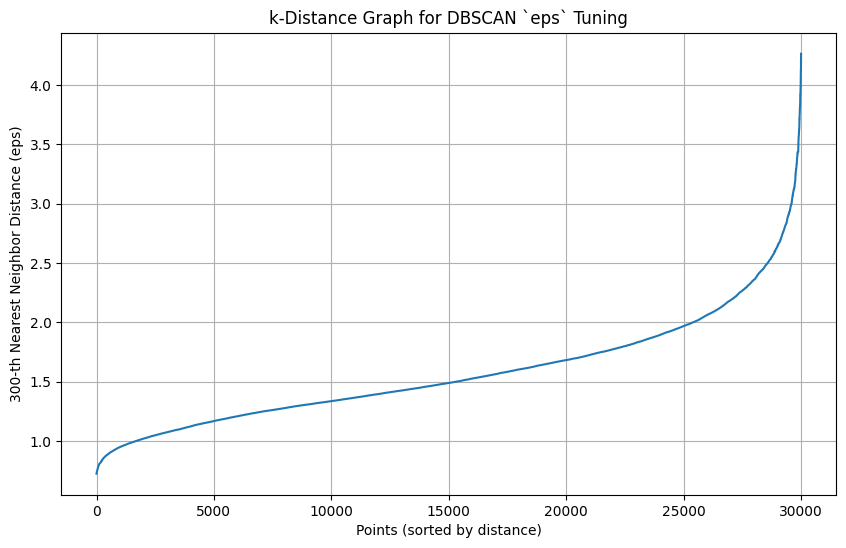

Find the 'elbow' of this curve to choose your 'eps' value.


In [ ]:
sample_size = min(30000, advanced_features.shape[0])
sample_indices = np.random.choice(advanced_features.shape[0], sample_size, replace=False)
features_sample = advanced_features[sample_indices, :]
MIN_SAMPLES = int(0.01 * features_sample.shape[0])
tune_dbscan_eps(features_sample,  min_samples=MIN_SAMPLES)

### Apply DBSCAN

In [ ]:
## i got "Your session crashed after using all available RAM"

OPTIMAL_EPS = 1.5

# Apply DBSCAN with the tuned parameters
print(f"\nRunning DBSCAN with eps={OPTIMAL_EPS} and min_samples={MIN_SAMPLES}...")
dbscan = DBSCAN(eps=OPTIMAL_EPS, min_samples=MIN_SAMPLES, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(advanced_features)

outlier_mask = np.zeros_like(dbscan_labels, dtype=np.uint8)
outlier_mask[dbscan_labels == -1] = 255 # Outliers are -1
outlier_mask = outlier_mask.reshape(h, w)

# We can also use a morphological close to clean up the result
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
outlier_mask_closed = cv2.morphologyEx(outlier_mask, cv2.MORPH_CLOSE, kernel)


Running DBSCAN with eps=1.5 and min_samples=300...


### Visualize the outliers

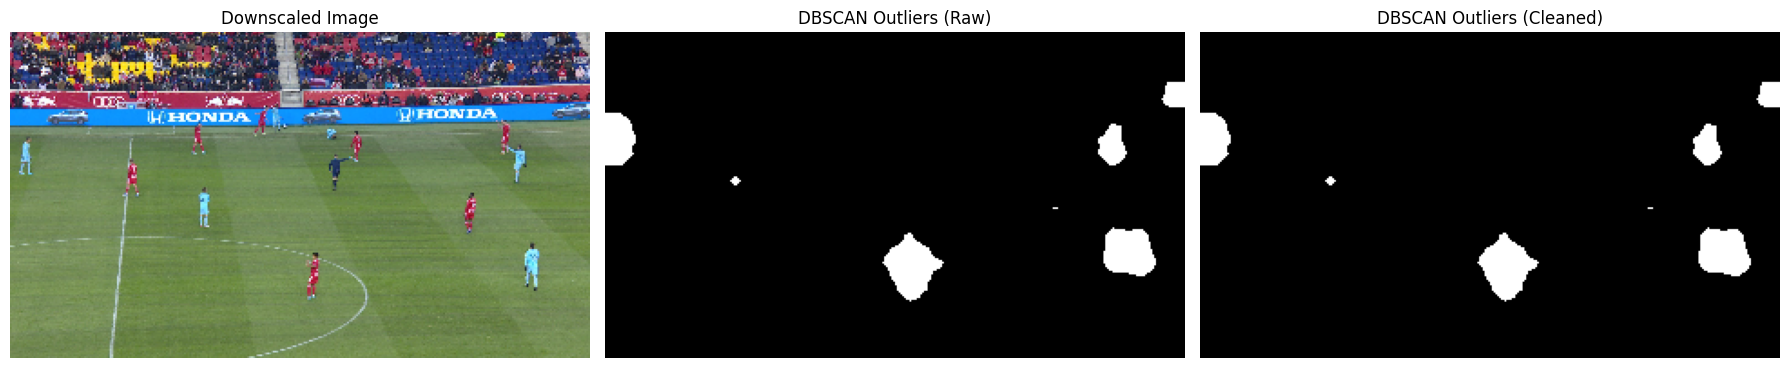

In [ ]:
plt.figure(figsize=(18, 6))
img_bgr = cv2.imread(img_path)
img_resized = cv2.resize(img_bgr, (w, h))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title('Downscaled Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(outlier_mask, cmap='gray')
plt.title('DBSCAN Outliers (Raw)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(outlier_mask_closed, cmap='gray')
plt.title('DBSCAN Outliers (Cleaned)')
plt.axis('off')

plt.tight_layout()
plt.show()

###why DBSCAN shows this behaviour

The features extracted by ResNet for all the grass pixels are very similar to each other, creating a single, massive, high-density region in the feature space. In contrast, the features for the player pixels are different from the grass and from each other, and they are sparsely distributed.

By setting a high min_samples threshold, we define a "dense" region as one containing a very large number of similar points. Only the grass field can meet this strict criterion. By setting a tight eps, we ensure that only points that are very close to this dense region are included in it.

Because the players' feature vectors are far from the main grass cluster and are not numerous enough to form their own "dense" region, DBSCAN correctly classifies them as noise/outliers (label -1). This is a powerful technique to isolate unique objects from a large, uniform background.

# 7. Evaluation 🧪

## Helper functions

In [ ]:
def extract_features_lab_xy(image_bgr):
    """Extracts features using the Lab color space and XY coordinates."""
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab).astype(np.float32)
    h, w = image_lab.shape[:2]
    flat_lab = image_lab.reshape(-1, 3)

    x_coords = np.linspace(0, 1, w, dtype=np.float32)
    y_coords = np.linspace(0, 1, h, dtype=np.float32)
    X_norm = np.tile(x_coords[np.newaxis, :], (h, 1))
    Y_norm = np.tile(y_coords[:, np.newaxis], (1, w))

    flat_x = X_norm.reshape(-1, 1)
    flat_y = Y_norm.reshape(-1, 1)
    features = np.concatenate([flat_lab, flat_x, flat_y], axis=1)
    return features

def perform_clustering_dbscan(features, eps, min_samples):
    """Performs DBSCAN clustering on scaled features."""
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(features_scaled)
    return labels

def perform_clustering_kmeans(features, k):
    """Performs K-Means clustering on scaled features."""
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

def filter_and_merge_clusters(labels, image_shape, min_size_threshold=100):
    """
    (This is your provided function, slightly modified for robustness)
    Filters out the largest cluster and small noise, then merges player segments.
    """
    h, w = image_shape

    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))

    if not cluster_sizes:
        return np.zeros((h, w), dtype=np.uint8)

    largest_cluster_id = max(cluster_sizes, key=cluster_sizes.get)

    labels_2d = labels.reshape(h, w)
    filtered_mask = np.zeros_like(labels_2d, dtype=np.uint8)

    for label_id, size in cluster_sizes.items():
        if label_id != largest_cluster_id and size > min_size_threshold:
            filtered_mask[labels_2d == label_id] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    merged_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return merged_mask

def load_annotations(json_path):
    """Loads and restructures a COCO-style JSON annotation file."""
    with open(json_path, 'r') as f: data = json.load(f)
    image_id_to_filename = {img['id']: img['file_name'] for img in data.get('images', [])}
    annotation_dict = {}
    for ann in data.get('annotations', []):
        image_id = ann.get('image_id')
        if image_id in image_id_to_filename:
            filename = image_id_to_filename[image_id]
            if filename not in annotation_dict: annotation_dict[filename] = []
            annotation_dict[filename].append(ann)
    return annotation_dict

def create_ground_truth_mask(annotations, target_shape, original_shape):
    """Creates a binary ground-truth mask, dynamically scaling polygons."""
    target_h, target_w = target_shape
    original_h, original_w = original_shape
    gt_mask = np.zeros((target_h, target_w), dtype=np.uint8)
    if not annotations: return gt_mask
    scale_w, scale_h = target_w / original_w, target_h / original_h
    for ann in annotations:
        for poly in ann.get('segmentation', []):
            if isinstance(poly, list) and len(poly) > 0:
                scaled_points = (np.array(poly, dtype=np.float32).reshape((-1, 2)) * np.array([scale_w, scale_h])).astype(np.int32)
                cv2.fillPoly(gt_mask, [scaled_points], color=255)
    return gt_mask

def calculate_iou(gt_mask, pred_mask):
    """Calculates the Intersection over Union (IoU) score."""
    gt_mask_bool, pred_mask_bool = gt_mask > 0, pred_mask > 0
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool).sum()
    union = np.logical_or(gt_mask_bool, pred_mask_bool).sum()
    return intersection / union if union > 0 else 0.0

def calculate_dice(gt_mask, pred_mask):
    """Calculates the Dice Coefficient."""
    gt_mask_bool, pred_mask_bool = gt_mask > 0, pred_mask > 0
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool).sum()
    total_area = gt_mask_bool.sum() + pred_mask_bool.sum()
    return (2. * intersection) / total_area if total_area > 0 else 0.0

## configuration

In [ ]:
#DBSCAN Parameters
OPTIMAL_EPS = 0.45
MIN_SAMPLES = 120

# K-Means Parameter
OPTIMAL_K = 5

# Your Filter Parameter
MIN_PLAYER_SIZE = 90

ANNOTATIONS_PATH = Path("football_data/annotations/instances_default.json")
DOWNSCALED_DIR = Path("sample_images_downscaled")
ORIGINAL_DIR = Path("football_data/images")

## Main evaluation script (DBSCAN)

In [ ]:
# LOAD DATA
image_filenames = [f.name for f in DOWNSCALED_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']]
all_annotations = load_annotations(ANNOTATIONS_PATH)
iou_scores, dice_scores = [], []

print("Starting Evaluation Loop:")
for image_name in image_filenames:
    img_downscaled = cv2.imread(str(DOWNSCALED_DIR / image_name))
    if img_downscaled is None: continue
    h_down, w_down = img_downscaled.shape[:2]

    print(f"Processing {image_name}...")

    # Generate Predicted Mask
    features = extract_features_lab_xy(img_downscaled)
    dbscan_labels = perform_clustering_dbscan(features, eps=OPTIMAL_EPS, min_samples=MIN_SAMPLES)
    predicted_mask = filter_and_merge_clusters(dbscan_labels, image_shape=(h_down, w_down), min_size_threshold=MIN_PLAYER_SIZE)

    # Create Ground-Truth Mask
    if image_name in all_annotations:
        img_original = cv2.imread(str(ORIGINAL_DIR / image_name))
        if img_original is None: continue
        original_h, original_w = img_original.shape[:2]
        gt_mask = create_ground_truth_mask(all_annotations[image_name], target_shape=(h_down, w_down), original_shape=(original_h, original_w))
    else:
        print(f"Warning: No annotation for {image_name}. Skipping.")
        continue

    # Calculate Scores
    iou = calculate_iou(gt_mask, predicted_mask)
    dice = calculate_dice(gt_mask, predicted_mask)
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"  IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Clean up memory
    del features
    del dbscan_labels
    del predicted_mask
    del gt_mask
    gc.collect()

if iou_scores:
    print(f"\n--- Evaluation Complete ---")
    print(f"Average IoU Score over {len(iou_scores)} images: {np.mean(iou_scores):.4f}")
    print(f"Average Dice Score over {len(dice_scores)} images: {np.mean(dice_scores):.4f}")
else:
    print("\nNo images were evaluated.")

--- Starting Evaluation Loop ---
Processing 201.jpg...
  IoU: 0.0732, Dice: 0.1364
Processing 407.jpg...
  IoU: 0.0822, Dice: 0.1519
Processing 170.jpg...
  IoU: 0.0752, Dice: 0.1400
Processing 91.jpg...
  IoU: 0.0742, Dice: 0.1381
Processing 494.jpg...
  IoU: 0.0986, Dice: 0.1795
Processing 278.jpg...
  IoU: 0.0949, Dice: 0.1733
Processing 478.jpg...
  IoU: 0.0778, Dice: 0.1444
Processing 246.jpg...
  IoU: 0.0767, Dice: 0.1424
Processing 32.jpg...
  IoU: 0.0833, Dice: 0.1537
Processing 51.jpg...
  IoU: 0.1397, Dice: 0.2451
Processing 37.jpg...
  IoU: 0.0899, Dice: 0.1649
Processing 347.jpg...
  IoU: 0.1393, Dice: 0.2445
Processing 403.jpg...
  IoU: 0.1021, Dice: 0.1854
Processing 498.jpg...
  IoU: 0.1091, Dice: 0.1967
Processing 510.jpg...
  IoU: 0.1102, Dice: 0.1986
Processing 169.jpg...
  IoU: 0.0818, Dice: 0.1512
Processing 475.jpg...
  IoU: 0.0803, Dice: 0.1486
Processing 108.jpg...
  IoU: 0.1291, Dice: 0.2286
Processing 69.jpg...
  IoU: 0.0796, Dice: 0.1474
Processing 300.jpg...


## visualize the last result for a qualitative check


--- Visualizing Last Processed Image: 346.jpg ---


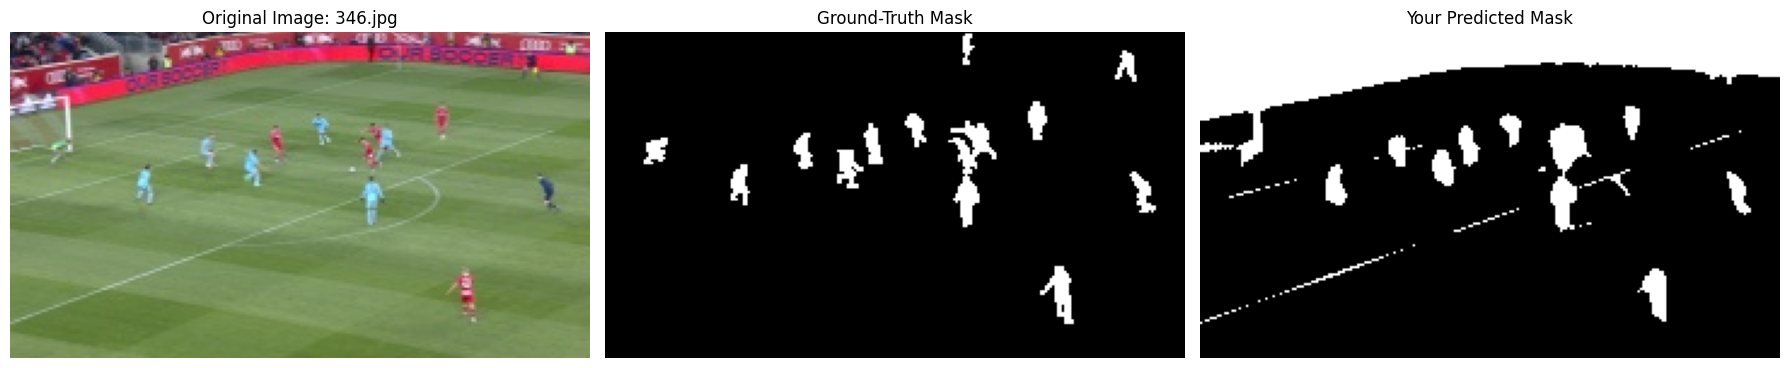

In [ ]:
# Rerun the pipeline for the last image
img_downscaled = cv2.imread(str(DOWNSCALED_DIR / image_name))
img_original = cv2.imread(str(ORIGINAL_DIR / image_name))
h_down, w_down = img_downscaled.shape[:2]
original_h, original_w = img_original.shape[:2]

# Generate the Predicted Mask again
features = extract_features_lab_xy(img_downscaled)
dbscan_labels = perform_clustering_dbscan(features, eps=OPTIMAL_EPS, min_samples=MIN_SAMPLES)
predicted_mask = filter_and_merge_clusters(dbscan_labels, image_shape=(h_down, w_down), min_size_threshold=MIN_PLAYER_SIZE)

# Generate the Ground-Truth Mask again
gt_mask = create_ground_truth_mask(all_annotations[image_name], target_shape=(h_down, w_down), original_shape=(original_h, original_w))

# Create the 3-panel plot
plt.figure(figsize=(18, 6))

# Panel 1: Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_downscaled, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image: {image_name}")
plt.axis('off')

# Panel 2: Ground-Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground-Truth Mask")
plt.axis('off')

# Panel 3: Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Your Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

## Interactive Tuning Script (Using Your Filter Logic)

--- Starting Interactive Tuning using your filter logic ---
Parameters: eps=0.45, min_samples=120, min_player_size=150



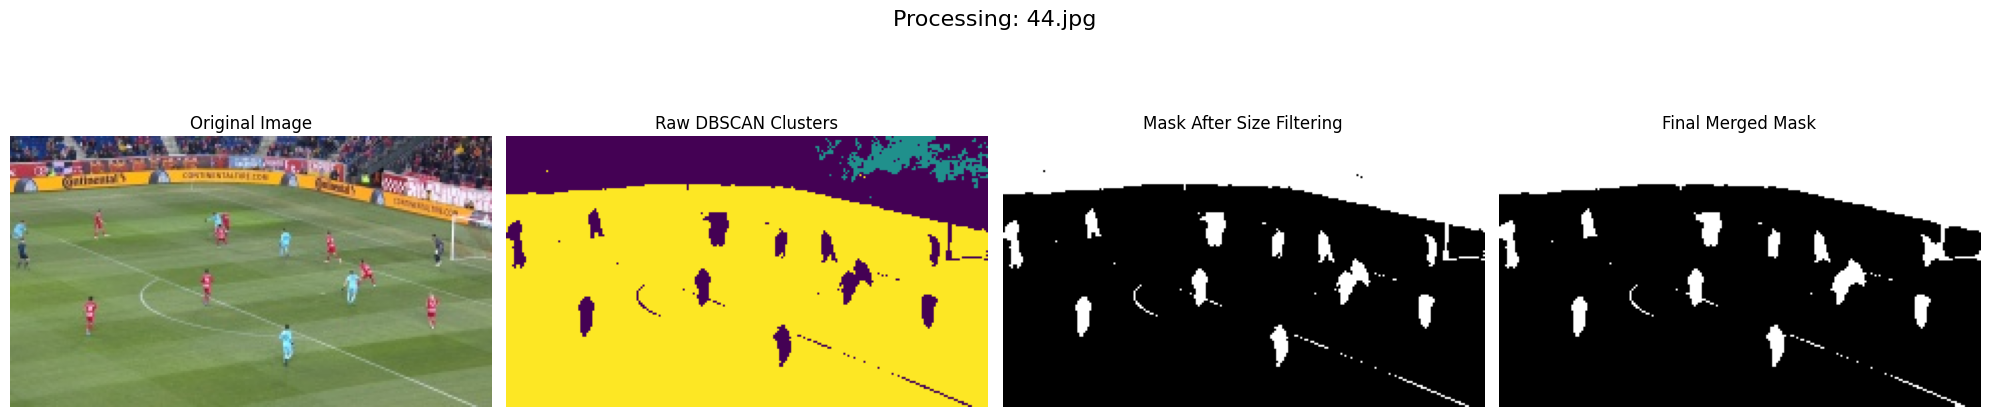

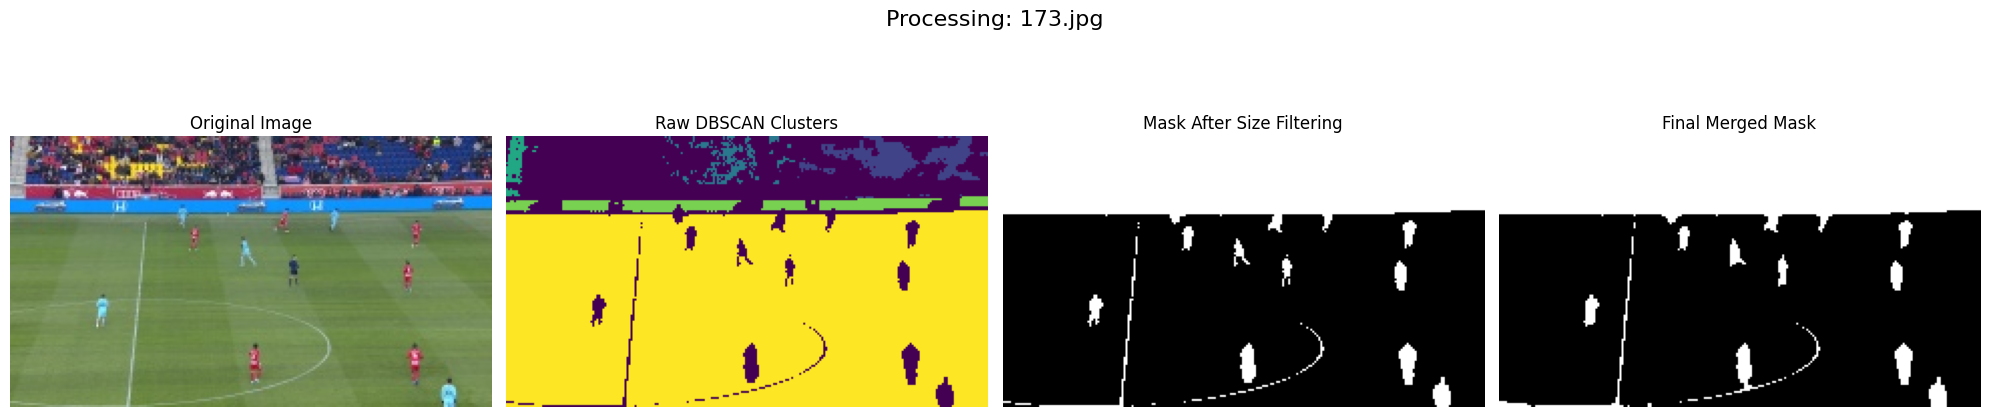

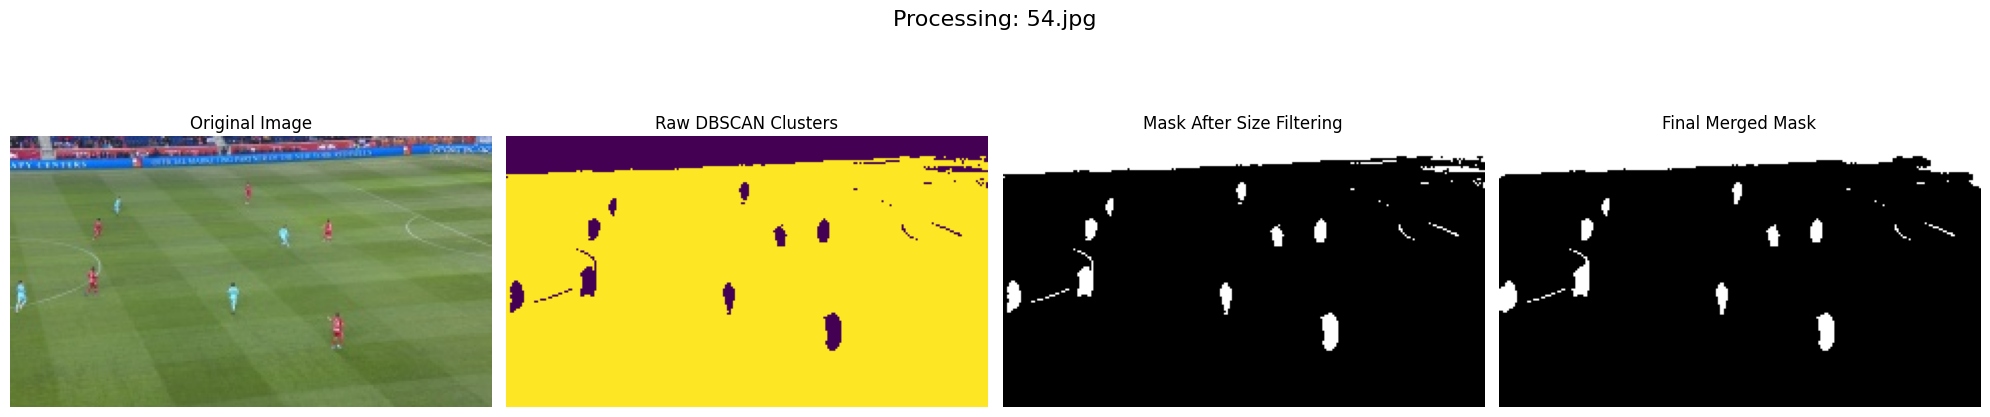

KeyboardInterrupt: 

In [ ]:
# DBSCAN Parameters
OPTIMAL_EPS = 0.45
MIN_SAMPLES = 120

# Your Filter Parameter
MIN_PLAYER_SIZE = 100

# SETUP
DOWNSCALED_DIR = Path("sample_images_downscaled")
all_filenames = [f.name for f in DOWNSCALED_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']]
sample_filenames = random.sample(all_filenames, min(10, len(all_filenames)))

print(f"--- Starting Interactive Tuning using your filter logic ---")
print(f"Parameters: eps={OPTIMAL_EPS}, min_samples={MIN_SAMPLES}, min_player_size={MIN_PLAYER_SIZE}\n")

# TUNING LOOP
for image_name in sample_filenames:
    img_downscaled = cv2.imread(str(DOWNSCALED_DIR / image_name))
    if img_downscaled is None: continue
    h, w = img_downscaled.shape[:2]

    # Run the pipeline
    features = extract_features_lab_xy(img_downscaled)
    labels = perform_clustering_dbscan(features, eps=OPTIMAL_EPS, min_samples=MIN_SAMPLES)
    filtered_mask, final_mask = filter_and_merge_clusters(labels, image_shape=(h, w), min_size_threshold=MIN_PLAYER_SIZE)

    # Visualize the step-by-step results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Processing: {image_name}', fontsize=16)

    axes[0].imshow(cv2.cvtColor(img_downscaled, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(labels.reshape(h, w), cmap='viridis')
    axes[1].set_title("Raw DBSCAN Clusters")
    axes[1].axis('off')

    axes[2].imshow(filtered_mask, cmap='gray')
    axes[2].set_title("Mask After Size Filtering")
    axes[2].axis('off')

    axes[3].imshow(final_mask, cmap='gray')
    axes[3].set_title("Final Merged Mask")
    axes[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    del features
    del labels
    gc.collect()

## Main evaluation script (K-means)

--- Starting Evaluation Loop ---
Processing 201.jpg...
  IoU: 0.0348, Dice: 0.0673
Processing 407.jpg...
  IoU: 0.0486, Dice: 0.0927
Processing 170.jpg...
  IoU: 0.0229, Dice: 0.0447
Processing 91.jpg...
  IoU: 0.0356, Dice: 0.0687
Processing 494.jpg...
  IoU: 0.0372, Dice: 0.0718
Processing 278.jpg...
  IoU: 0.0353, Dice: 0.0682
Processing 478.jpg...
  IoU: 0.0266, Dice: 0.0518
Processing 246.jpg...
  IoU: 0.0320, Dice: 0.0621
Processing 32.jpg...
  IoU: 0.0428, Dice: 0.0821
Processing 51.jpg...
  IoU: 0.0300, Dice: 0.0582
Processing 37.jpg...
  IoU: 0.0455, Dice: 0.0871
Processing 347.jpg...
  IoU: 0.0354, Dice: 0.0683
Processing 403.jpg...
  IoU: 0.0422, Dice: 0.0810
Processing 498.jpg...
  IoU: 0.0340, Dice: 0.0657
Processing 510.jpg...
  IoU: 0.0348, Dice: 0.0672
Processing 169.jpg...
  IoU: 0.0262, Dice: 0.0511
Processing 475.jpg...
  IoU: 0.0170, Dice: 0.0335
Processing 108.jpg...
  IoU: 0.0370, Dice: 0.0714
Processing 69.jpg...
  IoU: 0.0199, Dice: 0.0390
Processing 300.jpg...


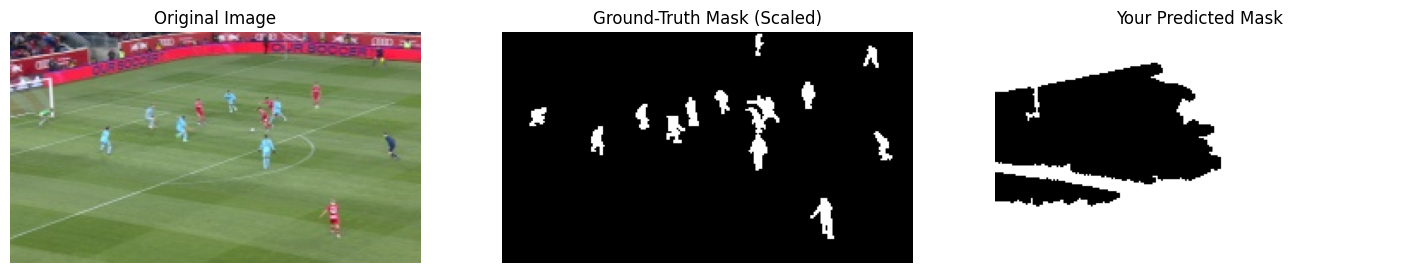

In [ ]:
image_filenames = [f.name for f in DOWNSCALED_DIR.iterdir() if f.suffix.lower() in ['.jpg', '.png']]
all_annotations = load_annotations(ANNOTATIONS_PATH)
iou_scores, dice_scores = [], []

print("Starting K-Means Evaluation Loop:")
for image_name in image_filenames:
    img_downscaled = cv2.imread(str(DOWNSCALED_DIR / image_name))
    if img_downscaled is None: continue
    h_down, w_down = img_downscaled.shape[:2]

    print(f"Processing {image_name}...")

    # Generate Predicted Mask
    features = extract_features_lab_xy(img_downscaled)
    kmeans_labels = perform_clustering_kmeans(features, k=OPTIMAL_K)
    predicted_mask = filter_and_merge_clusters(kmeans_labels, image_shape=(h_down, w_down), min_size_threshold=MIN_PLAYER_SIZE)

    # Create Ground-Truth Mask
    if image_name in all_annotations:
        img_original = cv2.imread(str(ORIGINAL_DIR / image_name))
        if img_original is None: continue
        original_h, original_w = img_original.shape[:2]
        gt_mask = create_ground_truth_mask(all_annotations[image_name], target_shape=(h_down, w_down), original_shape=(original_h, original_w))
    else:
        print(f"Warning: No annotation for {image_name}. Skipping.")
        continue

    # Calculate Scores
    iou = calculate_iou(gt_mask, predicted_mask)
    dice = calculate_dice(gt_mask, predicted_mask)
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"  IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Clean up memory
    del features
    del kmeans_labels
    del predicted_mask
    del gt_mask
    gc.collect()

# FINAL RESULTS
if iou_scores:
    print(f"\n--- Evaluation Complete ---")
    print(f"Average IoU Score over {len(iou_scores)} images: {np.mean(iou_scores):.4f}")
    print(f"Average Dice Score over {len(dice_scores)} images: {np.mean(dice_scores):.4f}")
else:
    print("\nNo images were evaluated.")

## visualize the last result for a qualitative check

In [ ]:
# Rerun the pipeline for the last image
img_downscaled = cv2.imread(str(DOWNSCALED_DIR / image_name))
img_original = cv2.imread(str(ORIGINAL_DIR / image_name))
h_down, w_down = img_downscaled.shape[:2]
original_h, original_w = img_original.shape[:2]

# Generate the Predicted Mask again
features = extract_features_lab_xy(img_downscaled)
kmeans_labels = perform_clustering_kmeans(features, k=OPTIMAL_K)
predicted_mask = filter_and_merge_clusters(kmeans_labels, image_shape=(h_down, w_down), min_size_threshold=MIN_PLAYER_SIZE)

# Generate the Ground-Truth Mask again
gt_mask = create_ground_truth_mask(all_annotations[image_name], target_shape=(h_down, w_down), original_shape=(original_h, original_w))

# Create the 3-panel plot
plt.figure(figsize=(18, 6))

# Panel 1: Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_downscaled, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image: {image_name}")
plt.axis('off')

# Panel 2: Ground-Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground-Truth Mask")
plt.axis('off')

# Panel 3: Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Your Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

 # 8. Questions ❓

### 1. Segmentation Types: Semantic, Instance, and Panoptic

**Provide an example of a segmentation task where each type of segmentation is appropriate and sufficient, and explain why.**

* **Semantic Segmentation**
    * **Concept:** Assigns a class label (like "road," "sky," "person") to every pixel in an image. It doesn't distinguish between different objects of the same class.
    * **Example Task:** Identifying drivable terrain for an autonomous vehicle.
    * **Why it's sufficient:** The car's primary goal is to know which pixels belong to the "road" class so it can drive on them, and which belong to "sidewalk," "building," or "tree" classes so it can avoid them. It doesn't need to know if there are two different trees; it just needs to know the single category "tree."

* **Instance Segmentation**
    * **Concept:** Detects and segments each individual *object* in an image, giving each one a unique ID (e.g., "person 1," "person 2," "person 3").
    * **Example Task:** Counting the number of products on a store shelf for inventory management.
    * **Why it's sufficient:** The system's only goal is to identify and count distinct objects. It needs to know there are three separate "soda can" instances and five "cereal box" instances. It doesn't need to label the background pixels (the shelf or the floor).

* **Panoptic Segmentation**
    * **Concept:** Combines both semantic and instance segmentation. It provides a complete understanding of the scene by assigning a class label to *every* pixel, and also giving a unique ID to each individual object.
    * **Example Task:** A robotics application for a warehouse robot that organizes items.
    * **Why it's necessary:** The robot needs a total understanding of its environment. It needs to know the class of everything (semantic: "this is a box," "this is the floor," "this is a shelf") and also which specific object it is interacting with (instance: "pick up box #A5" and place it on "shelf #3"). This unified view is essential for complex interaction tasks.

---

### 2. Dice Coefficient vs. Intersection over Union (IoU)

**Explain the difference between the Dice coefficient and IoU as evaluation metrics in image segmentation. In what scenarios might one be preferred over the other?**

**IoU (Intersection over Union)** and the **Dice Coefficient** are both metrics used to measure the similarity and overlap between the predicted segmentation mask and the ground-truth mask.

* **IoU:** Calculated as the area of the overlap divided by the total area of the union.
    * `IoU = |Intersection| / |Union|`
    * It's very intuitive, representing the percentage of overlap between the two masks. It is a stricter metric because it penalizes false positives and false negatives equally.

* **Dice Coefficient:** Calculated as twice the area of the overlap divided by the sum of the areas of both masks.
    * `Dice = (2 * |Intersection|) / (|Predicted Area| + |Ground-Truth Area|)`
    * The Dice score gives more weight to the intersection (the correctly identified pixels).

**When to Prefer One Over the Other:**

* **Prefer IoU** as a general-purpose, standard metric. It is widely used in many computer vision benchmarks (like COCO) and is very easy to interpret. Its strictness makes it a good overall measure of performance.

* **Prefer the Dice Coefficient** in scenarios with **severe class imbalance**, which is very common in **medical imaging**. For example, when segmenting a small tumor from a large MRI scan, the vast majority of pixels are background. The Dice score is less sensitive to the large number of true negatives (correctly identified background pixels) and focuses more on how well the small positive region (the tumor) was segmented. This makes it a more stable and meaningful metric for tasks involving small objects.

---

### 3. Autoencoders for Image Clustering

**Explain how autoencoders can be used for clustering a large set of images and how this improves the efficiency and effectiveness of algorithms like K-means.**

The main challenge with clustering raw images is the **"curse of dimensionality."** A simple 100x100 pixel image is a 10,000-dimensional data point. K-means performs poorly in such high-dimensional spaces because the concept of distance becomes less meaningful. Autoencoders solve this by learning a compressed, low-dimensional representation of the images.

**How it Works:**

An **autoencoder** is an unsupervised neural network with two main parts:
1.  **Encoder:** This part of the network takes the high-dimensional input (the image) and compresses it down to a small, dense, low-dimensional vector. This vector is called the **latent representation** or **embedding**.
2.  **Decoder:** This part takes the compressed latent vector and tries to reconstruct the original image from it.

The network is trained to minimize the difference between the original and reconstructed images. In doing so, the encoder learns to capture the most important, semantic features of the images in its compact latent vector.

**The process for clustering is as follows:**
1.  Train an autoencoder on your entire dataset of images.
2.  After training is complete, **discard the decoder**.
3.  Pass all of your images through the **trained encoder only**. This converts each high-dimensional image into a meaningful, low-dimensional feature vector (e.g., a 32-dimensional vector instead of a 10,000-dimensional one).
4.  Run your clustering algorithm (like K-means) on this new dataset of low-dimensional feature vectors.

**How this Improves Efficiency and Effectiveness:**

* **Efficiency (Faster):** K-means is vastly more efficient when calculating distances between points in a low-dimensional space (e.g., 32 dimensions) compared to a high-dimensional one (10,000 dimensions). The number of computations is dramatically reduced, making the clustering process much faster.
* **Effectiveness (Better Results):** The autoencoder's latent vectors are not just smaller; they are *smarter*. They represent the "essence" of an image (e.g., "cat," "pointy ears," "whiskers") while ignoring irrelevant noise and pixel variations. Clustering on these rich, semantic features produces much more meaningful and accurate groups than clustering on raw, noisy pixel data.